<a href="https://colab.research.google.com/github/NirajBagh/Anamoly-Detection-using-Autoencoder/blob/main/anomaly_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center> <h2>Vibration Anomaly Detection</h2> </center>


**Goal** : An anomaly detection model for vibration failure dataset


**Dataset** : vibration sensor readings from four bearings. Dataset is sourced from The NASA Acoustics and Vibration Database

## A. Loading of Dataset

In [5]:
# importing packages
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
sns.set(color_codes=True)
import glob
import os
import pickle
import joblib
from keras.layers import Dense
from keras.models import Model, Sequential, load_model
from keras import regularizers

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
data_dir = '/content/drive/MyDrive/Machine life detection/2nd_test'
merged_data = pd.DataFrame()

# Looping over all files from 12th Feb to 19th Feb
for filename in os.listdir(data_dir):
    dataset=pd.read_csv(os.path.join(data_dir, filename), sep='\t')
    dataset_mean_abs = np.array(dataset.abs().mean())
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
    dataset_mean_abs.index = [filename]
    merged_data = pd.concat([merged_data, dataset_mean_abs], ignore_index=False)

# Renaming columns
merged_data.columns = ['Bearing 1','Bearing 2','Bearing 3','Bearing 4']
# Identifying index as datetime format
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()
merged_data.to_csv('merged_dataset_BearingTest_2.csv')

In [7]:
df_filename = "merged_dataset_BearingTest_2.csv"
df = pd.read_csv(df_filename, index_col="Unnamed: 0")

## B. Exploratory Data Analysis

In [8]:
df

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
...,...,...,...,...
2004-02-19 05:42:39,0.453335,0.161016,0.137440,0.119047
2004-02-19 05:52:39,0.337583,0.132400,0.144992,0.092125
2004-02-19 06:02:39,0.351111,0.152266,0.151299,0.100817
2004-02-19 06:12:39,0.001857,0.003732,0.003656,0.001786


In [9]:
# total missing value each columns
for col in df.columns.tolist():
    print('{} column missing values: {}'.format(col, df[col].isnull().sum()))

Bearing 1 column missing values: 0
Bearing 2 column missing values: 0
Bearing 3 column missing values: 0
Bearing 4 column missing values: 0


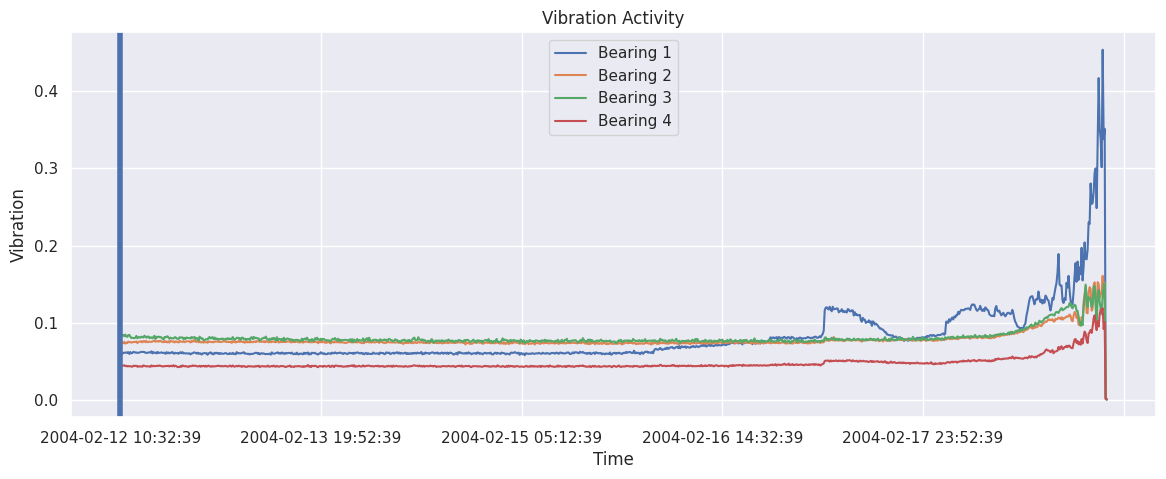

In [10]:
# Visualisation Data
ax = df.plot(figsize = (14,5), title="Vibration Activity" , legend = True)
ax.set(xlabel="Time", ylabel="Vibration")
plt.axvline(x=df.index[-1], linewidth=4, color='b')

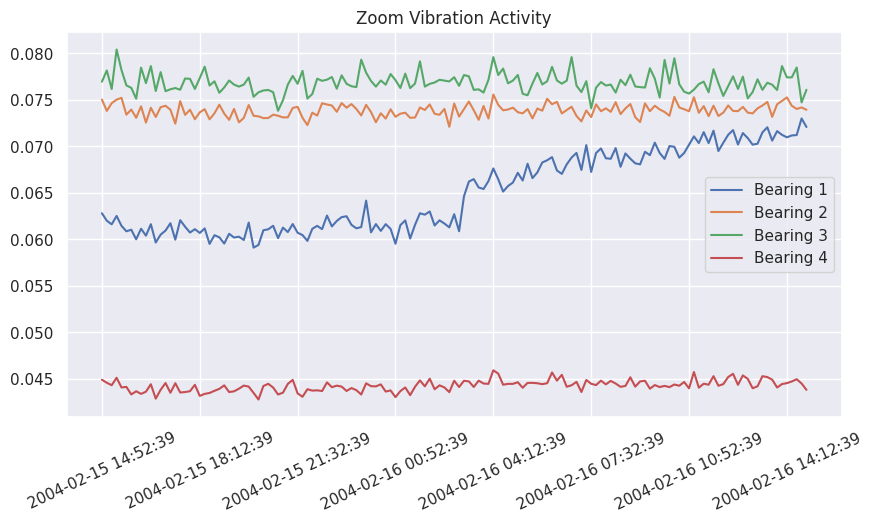

In [11]:
df['2004-02-15 14:52:39':'2004-02-16 14:52:39'].plot(figsize = (10,5), title="Zoom Vibration Activity" , legend = True)
ax.set(xlabel="Time", ylabel="Vibration")
plt.xticks(rotation=25);

>- **start_date** : 2004-02-12 10:52:39
>- **end_date** : 2004-02-19 06:22:39
>- **range** : 10 min
>- **missing values** : 0
>- **total data** : 982
>- Bearings vibration time series shows the characteristics of consistency range and predictability anomaly
>- Vibration Bearing 1 start increase before 2004-02-16 04:12:39

## C. Data Preparation

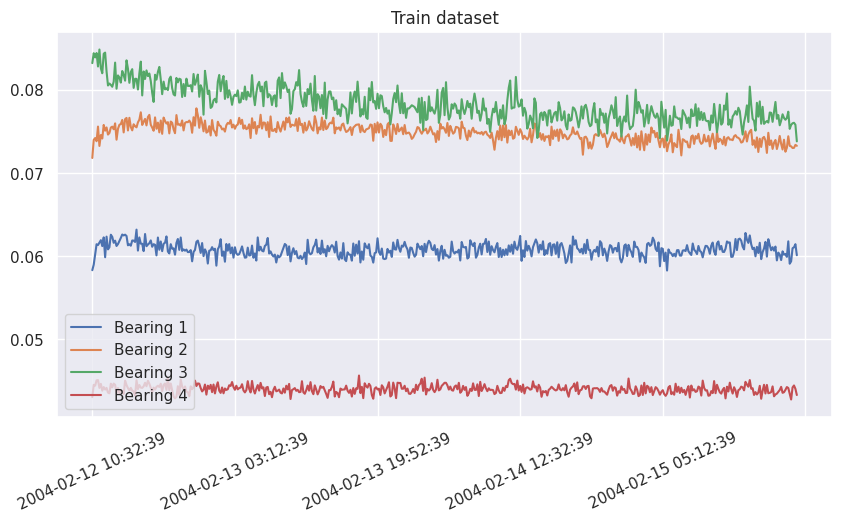

In [12]:
# split dataset
train_df = df[:'2004-02-15 20:52:39'] # represent normal operating conditions
test_df = df['2004-02-15 20:52:39':] # leading up to the bearing failure
train_df.plot(figsize = (10,5), title="Train dataset" , legend = True)
plt.xticks(rotation=25);

In [13]:
# Standardize the data.
scaler = StandardScaler()
scaler = scaler.fit(train_df)
x_train = pd.DataFrame(scaler.transform(train_df),
                       columns=train_df.columns, index=train_df.index)
x_test = pd.DataFrame(scaler.transform(test_df),
                       columns=test_df.columns, index=test_df.index)

### D. Modelling

**Comparing Methods**

 Comparing methods based on the Journal "Review of Vibration-Based Structural Health Monitoring Using Deep Learning" [1]. There are several studies related to vibration health monitoring on bearings, using the Sparse Autoencoder (SAE) and Denoising Autoencoder (DAE) methods.

<img src="image/table_1_comparing methods.png" alt="drawing" width="600"/>

<img src="image/table_2_comparing methods.png" alt="drawing" width="600"/>

In this task with relative stable dataset on normal operating conditions, the approach used is simpler and effective, Autoencoder.

# Autoencoder Technique

In [15]:
## modelling
for i, col_name in enumerate(df.columns):
    print('================= TRAINING %s =================='%col_name)
    curr_xtrain = np.array(x_train[[col_name]])

    autoencoder = Sequential()
    autoencoder.add(Dense(9,activation='elu',
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_shape=(curr_xtrain.shape[1],)))
    autoencoder.add(Dense(3,activation='elu',
                kernel_initializer='glorot_uniform'))
    autoencoder.add(Dense(9,activation='elu',
                kernel_initializer='glorot_uniform'))
    autoencoder.add(Dense(curr_xtrain.shape[1],
                kernel_initializer='glorot_uniform'))
    autoencoder.compile(optimizer='adam', loss="mse")

    # fitting the model
    hist = autoencoder.fit(curr_xtrain, curr_xtrain, batch_size=10,
                  epochs=30,validation_split=0.05,verbose = 1)

    # save model to model path
    autoencoder.save("model/model_%s.h5"%col_name)

    # visualize training-validation loss
    plt.plot(hist.history['loss'],'r',label='Training loss')
    plt.plot(hist.history['val_loss'],'b',label='Validation loss')
    plt.title("Training-Validation Loss %s"%col_name)
    plt.legend(loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss [mse]')
    plt.ylim([0,.1])
    plt.savefig('/content/drive/MyDrive/Machine life detection/Image_Auto_Encoder_Anamoly_Detection/plot_training-validation loss_%s.png'%col_name)

    plt.close()

    print('\n================== DONE ===================')

================= TRAINING Bearing 1 ==================
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.6977 - val_loss: 0.3983
Epoch 2/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2326 - val_loss: 0.0575
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0370 - val_loss: 0.0239
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0251 - val_loss: 0.0216
Epoch 5/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0191 - val_loss: 0.0179
Epoch 6/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0174 - val_loss: 0.0158
Epoch 7/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0184 - val_loss: 0.0139
Epoch 8/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0171 - val_loss: 0.0125
Epoch 9/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0152 - val_loss: 0.0116
Epoch 10/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0153 - val_loss: 0.0101
Epoch 11/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0109 - val_loss: 0.0101
Epoch 12/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0139 - val_loss: 0.0089



================== DONE ===================
================= TRAINING Bearing 2 ==================
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.8240 - val_loss: 0.9582
Epoch 2/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2925 - val_loss: 0.1137
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0497 - val_loss: 0.0171
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0241 - val_loss: 0.0175
Epoch 5/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0213 - val_loss: 0.0187
Epoch 6/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0203 - val_loss: 0.0215
Epoch 7/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0153 - val_loss: 0.0213
Epoch 8/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0188 - val_loss: 0.0241
Epoch 9/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0214 - val_loss: 0.0268
Epoch 10/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0191 - val_loss: 0.0249
Epoch 11/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0169 - val_loss: 0.0236
Epoch 12/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0164 - val_loss: 0.0247



================== DONE ===================
================= TRAINING Bearing 3 ==================
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.6902 - val_loss: 0.4642
Epoch 2/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2064 - val_loss: 0.1226
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0306 - val_loss: 0.0579
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0259 - val_loss: 0.0552
Epoch 5/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0299 - val_loss: 0.0526
Epoch 6/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0224 - val_loss: 0.0476
Epoch 7/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0221 - val_loss: 0.0453
Epoch 8/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0143 - val_loss: 0.0430
Epoch 9/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0229 - val_loss: 0.0413
Epoch 10/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0184 - val_loss: 0.0377
Epoch 11/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0189 - val_loss: 0.0359
Epoch 12/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0144 - val_loss: 0.0333



================== DONE ===================
================= TRAINING Bearing 4 ==================
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.9088 - val_loss: 0.4308
Epoch 2/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3146 - val_loss: 0.1313
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0669 - val_loss: 0.0630
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0350 - val_loss: 0.0575
Epoch 5/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0310 - val_loss: 0.0536
Epoch 6/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0329 - val_loss: 0.0504
Epoch 7/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0294 - val_loss: 0.0485
Epoch 8/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0263 - val_loss: 0.0438
Epoch 9/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0314 - val_loss: 0.0406
Epoch 10/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0311 - val_loss: 0.0382
Epoch 11/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0216 - val_loss: 0.0379
Epoch 12/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0220 - val_loss: 0.0361


================== DONE ===================


In [19]:
# list training-validasion loss images saved
list_loss_plot = sorted(glob.glob("/content/drive/MyDrive/Machine life detection/Image_Auto_Encoder_Anamoly_Detection*"))
list_loss_plot

['/content/drive/MyDrive/Machine life detection/Image_Auto_Encoder_Anamoly_Detection']

In [22]:
from keras.models import load_model
from keras.losses import MeanSquaredError

models = {}
for col_name in df.columns:
    models[col_name] = load_model(f"/content/model/model_{col_name}.h5", custom_objects={'mse': MeanSquaredError()})


### E. Prediction

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step


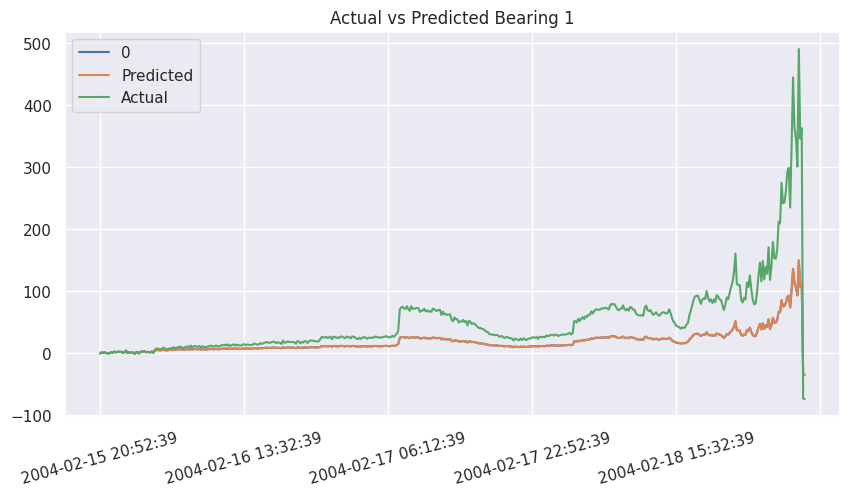

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


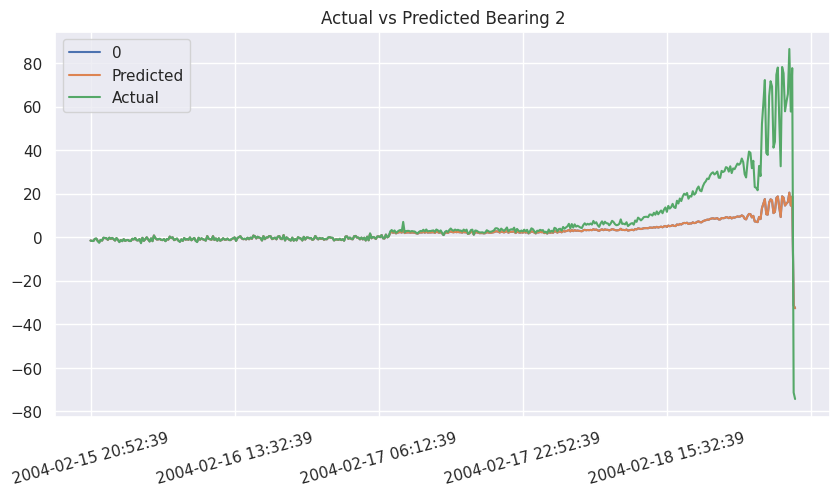

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


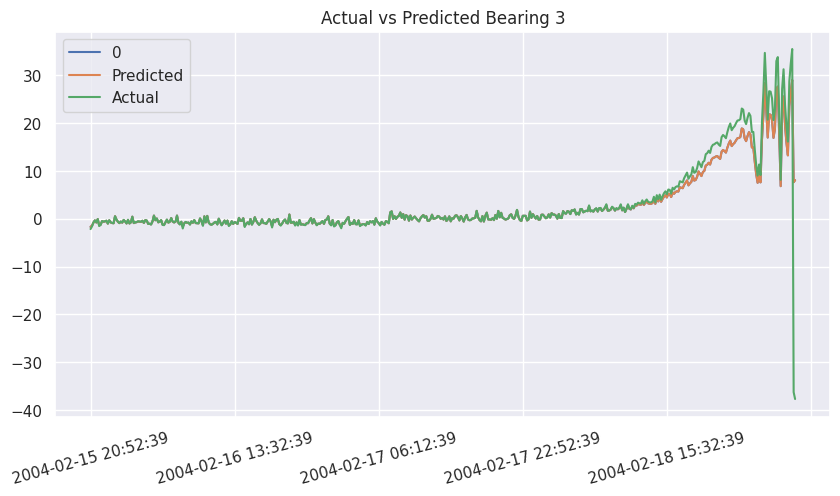

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


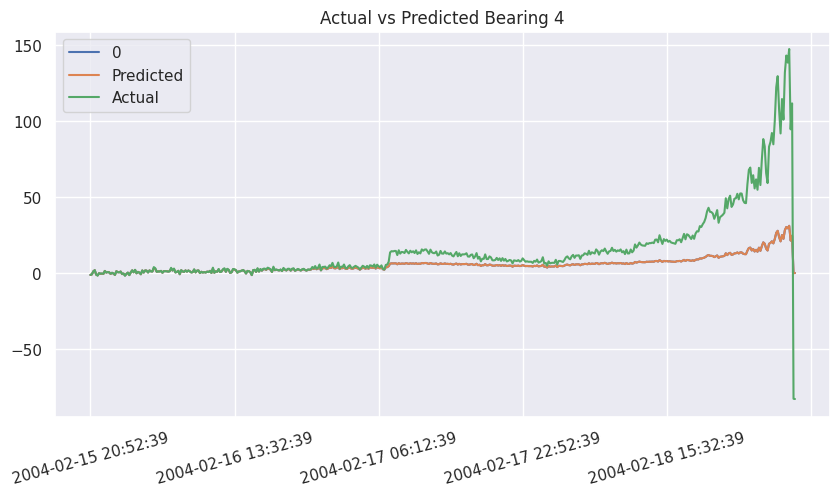

In [23]:
# visualization x_test prediction
# leading up to the bearing failure
for col in df.columns:
    x_test_array = np.array(x_test[col])
    x_test_pred = models[col].predict(x_test_array)

    df_test_pred = pd.DataFrame(x_test_pred)
    df_test_pred["Predicted"] = x_test_pred
    df_test_pred["Actual"] = x_test_array
    df_test_pred.index = x_test[col].index
    df_test_pred.plot(figsize = (10,5), title=f"Actual vs Predicted {col}" , legend = True)
    plt.xticks(rotation=15)
    plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


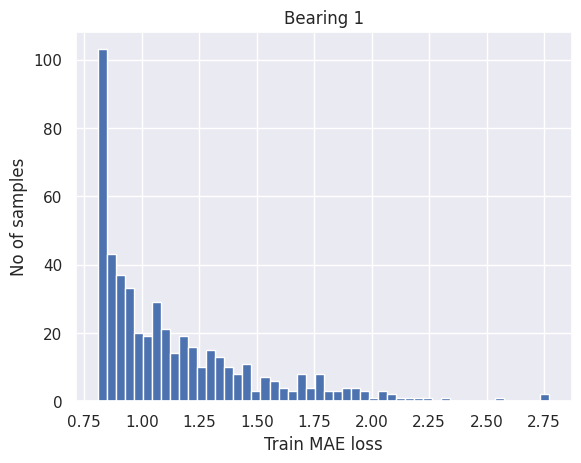

Reconstruction error threshold Bearing 1:  2.7712873541389937
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


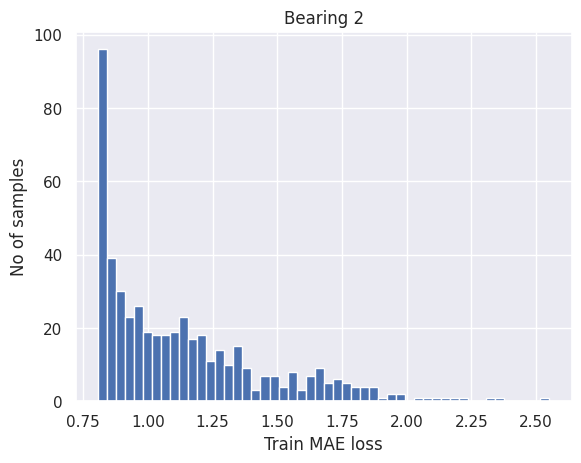

Reconstruction error threshold Bearing 2:  2.5500345718463495
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


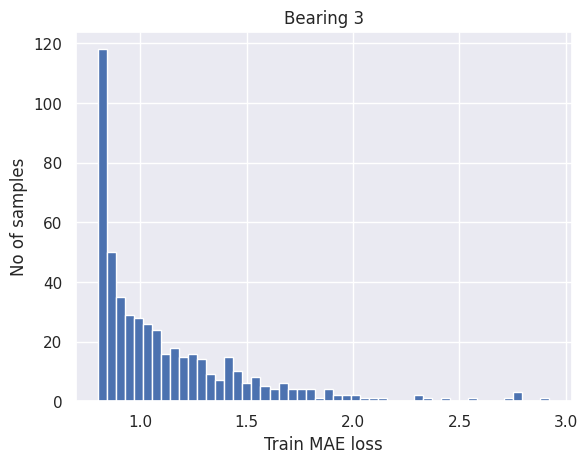

Reconstruction error threshold Bearing 3:  2.9212714731353913
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


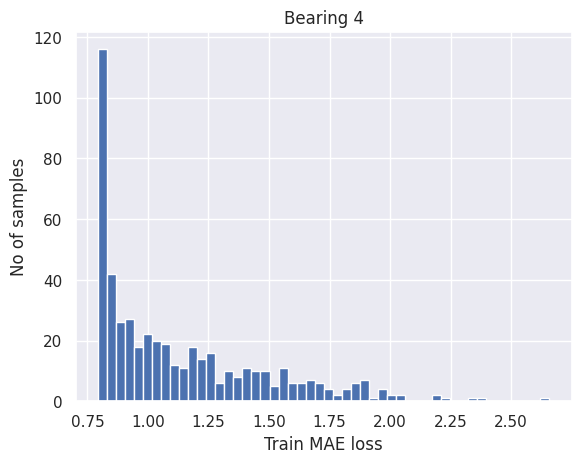

Reconstruction error threshold Bearing 4:  2.656357234570051


In [24]:
# Get train MAE loss.
list_threshold = []
for col in df.columns:
    x_train_pred = models[col].predict(np.array(x_train[col]))
    train_mae_loss = np.mean(np.abs(x_train_pred - np.array(x_train[col])),axis=1)

    plt.hist(train_mae_loss, bins=50)
    plt.xlabel("Train MAE loss")
    plt.ylabel("No of samples")
    plt.title(col)
    plt.show()

    # Get reconstruction loss threshold
    threshold = np.max(train_mae_loss)
    list_threshold.append(threshold)
    print(f"Reconstruction error threshold {col}: ", threshold)

## Existing

<ipython-input-26-3776c9ca4a30>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bands = [get_bands(x_test[col][range(0 if i - k < 0 else i - k,


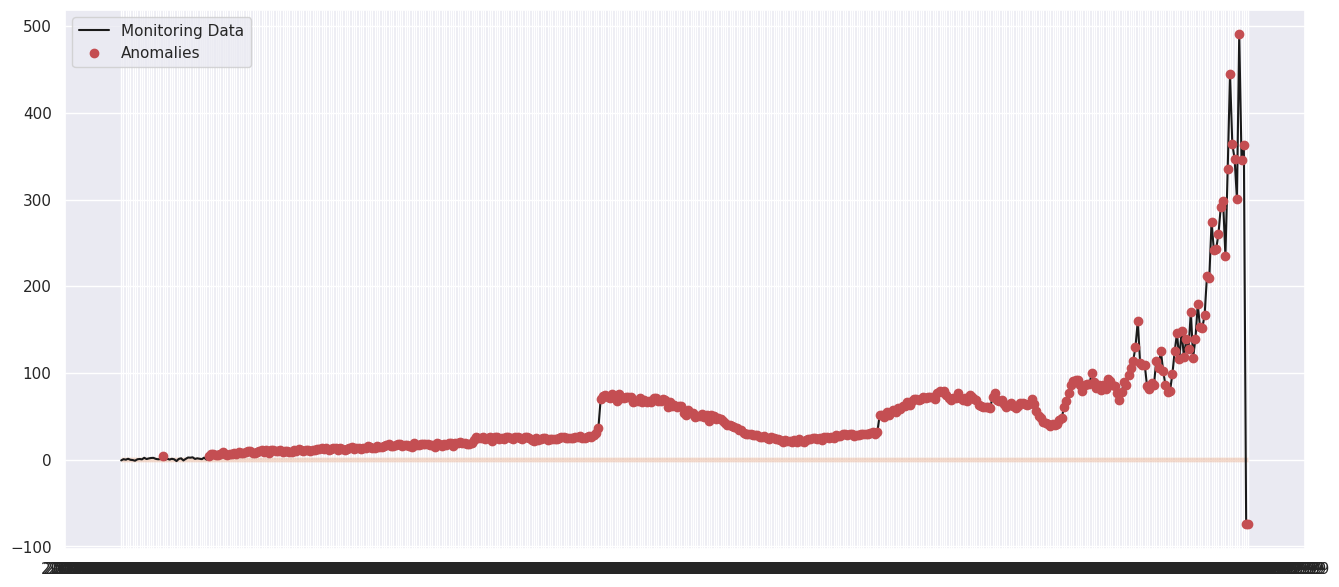

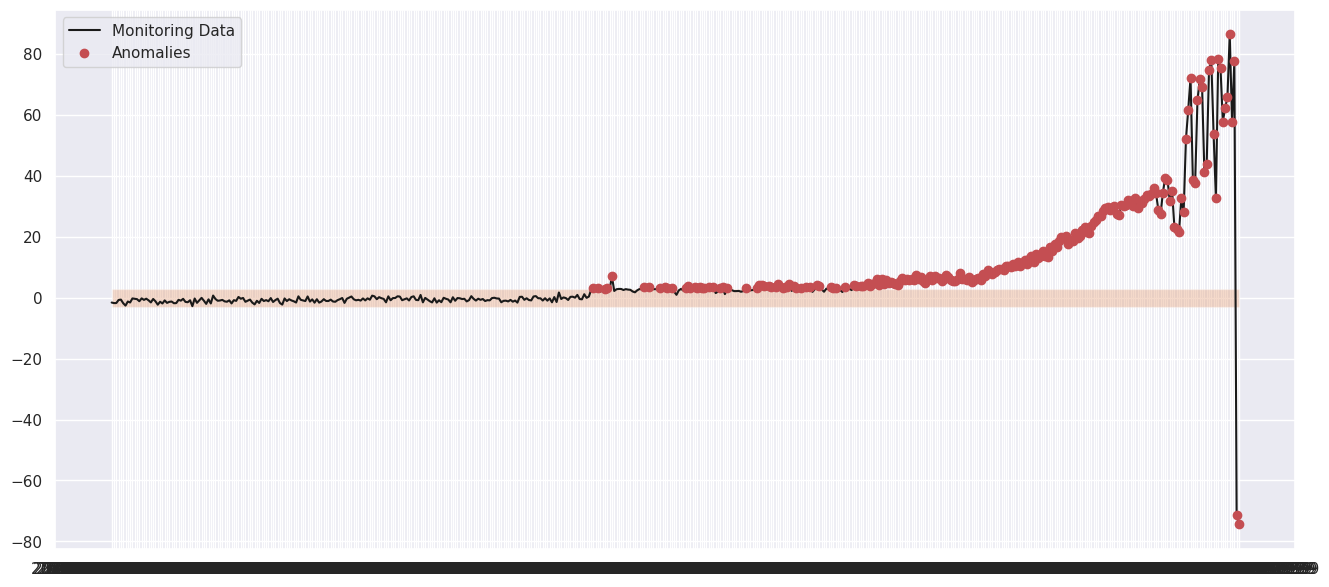

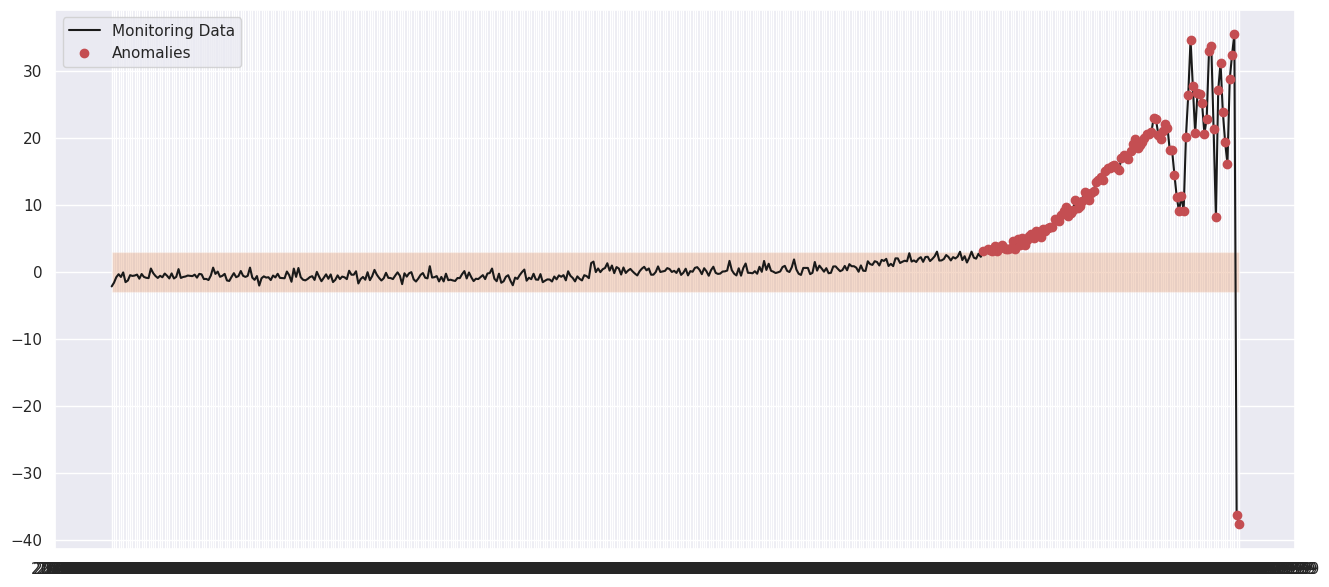

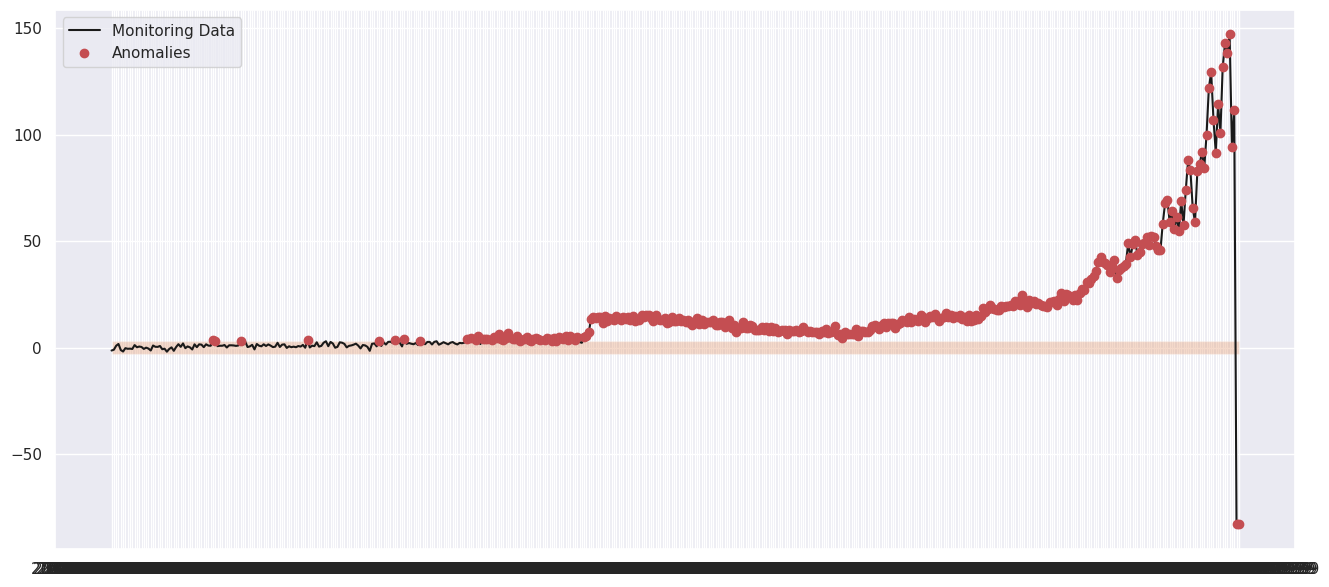

In [26]:
for col in df.columns:
    window_percentage = 20
    k = int(len(x_test[col]) * (window_percentage/100))
    N = len(x_test[col])

    get_bands = lambda data : (np.mean(x_train[col]) + 3*np.std(x_train[col]),
                               np.mean(x_train[col]) - 3*np.std(x_train[col]))

    bands = [get_bands(x_test[col][range(0 if i - k < 0 else i - k,
                                         i + k if i + k < N else N)]) for i in range(0, N)]
    upper, lower = zip(*bands)

    # compute local outliers
    anomalies = (x_test[col] > upper) | (x_test[col] < lower)

    # plotting
    plt.figure(figsize=(16, 7))
    plt.plot(x_test.index, x_test[col], 'k', label='Monitoring Data')
    plt.plot(x_test.index[anomalies], x_test[col][anomalies], 'ro', label='Anomalies')
    plt.fill_between(x_test.index, upper, lower, facecolor='C1', alpha=.3)
    plt.legend()
    plt.show()
